In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import tensorflow.keras as keras

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#NOTE: only use when you want to do convs
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
# model.add(tf.keras.layers.Dense(50, activation="relu"))
# model.add(tf.keras.layers.Dense(10, activation="softmax"))

n=2
# model = keras.Sequential(
#     [
#         #keras.Input(shape=(28, 28, 1)),
#         layers.Conv2D(n, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(2*n, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(n, activation="relu"),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

from customLayers.andlayer import ANDLayer
model = keras.Sequential(
    [
        #keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(n, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(2*n, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        ANDLayer(n),
        layers.Dense(10, activation="softmax"),
    ]
)

In [4]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, verbose=1, use_multiprocessing=False, validation_data=(x_test, y_test))

Epoch 1/3
1875/1875 [==============================] - 9s 5ms/step - loss: 1.6477 - accuracy: 0.3726 - val_loss: 1.0259 - val_accuracy: 0.6309
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 1.1969 - accuracy: 0.5523 - val_loss: 0.8819 - val_accuracy: 0.6936
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 1.1053 - accuracy: 0.6039 - val_loss: 0.8049 - val_accuracy: 0.7446


In [5]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [159]:
from random import randint

InputExample = randint(0, len(x_test)) #2332
modelInput = tf.constant([x_test[InputExample]])
predIndex = int(tf.argmax(model(modelInput), axis=1)[0])
print(int(tf.argmax(model(modelInput), axis=1)[0]))
#x_test
with tf.GradientTape() as tape:
    tape.watch([modelInput, model.output])
    y_ = model(modelInput)[:,predIndex]
#grads = tape.gradient(modelInput, y_)
grads = tape.gradient(y_, modelInput)

8


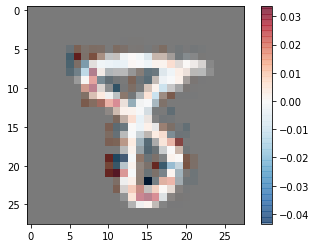

In [160]:
plt.figure()
plt.imshow(modelInput[0], cmap='gray')
plt.imshow(grads[0], cmap='RdBu_r', norm=colors.DivergingNorm(vmin=np.min(grads[0]), vcenter=0., vmax=np.max(grads[0])), alpha=.5)
plt.colorbar()

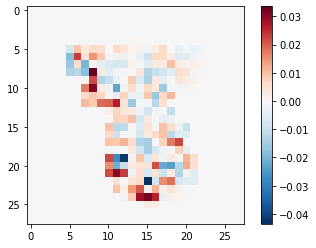

In [161]:

plt.imshow(grads[0], cmap='RdBu_r', norm=colors.DivergingNorm(vmin=np.min(grads[0]), vcenter=0., vmax=np.max(grads[0])))
plt.colorbar()

In [162]:
from tqdm import tqdm
import xarray
#group by class

# Model out
# ds = xarray.Dataset({'modelin': (["n","x","y","c"],np.array(x_test)), 'modelout': (["n"],np.array(tf.argmax(model(x_test), axis=1)))})
ds = xarray.Dataset({'modelin': (["n","x","y","c"],np.array(x_test)), 'modelout': (["n"],np.array(y_test,dtype=int))})

In [163]:
ds

<xarray.Dataset>
Dimensions:   (c: 1, n: 10000, x: 28, y: 28)
Dimensions without coordinates: c, n, x, y
Data variables:
    modelin   (n, x, y, c) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    modelout  (n) int32 7 2 1 0 4 1 4 9 5 9 0 6 9 ... 4 5 6 7 8 9 0 1 2 3 4 5 6

In [164]:
# $P33D!!!! (SPEED)
occupancy = 0

classGroupedData = ds.groupby("modelout")
for outClass, data in classGroupedData:
    print(outClass)
    batchedClass = tf.constant(np.array(data["modelin"]))
    with tf.GradientTape() as tape:
        tape.watch([batchedClass, model.output])
        y_ = model(batchedClass)[:,outClass]
        #grads = tape.gradient(modelInput, y_)
    grads = tape.gradient(y_, batchedClass)
    occupancy += np.sum(grads**2)

    #print(grads)
    #break
    

0
1
2
3
4
5
6
7
8
9


In [165]:
occupancy

3002.0150440347156